<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/src/dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.6 MB/s eta 0:00:00


In [2]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_original_RU.csv')
df.sample(10)

,comment,toxic
2061,"Какие же хохлы незалежные дегенераты, пиздец п...",1.0
13486,"Зато сейчас ни у талибов, ни у пендосов этот н...",1.0
14132,"Реальная фамилия Шульженок. Лол, опять хохлы з...",1.0
2889,"Анус свой потри, не неси свою хуйню с цензурой...",1.0
11691,Инфографику на бирже фриланса заказывали по де...,0.0
7421,"А с работой что, сами откуда? Подобные ваканси...",0.0
2175,"Началось все, когда он уехал в Тайланд на дово...",0.0
11766,А как в таком положении порнуху смотреть? Друг...,0.0
13540,Есть такая штука. Стоит что то около 4 лямов. ...,0.0
8355,Когда деньги пытаются заработать на жизни и зд...,0.0


In [4]:
df['comment'] = df['comment'].values.astype('U')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


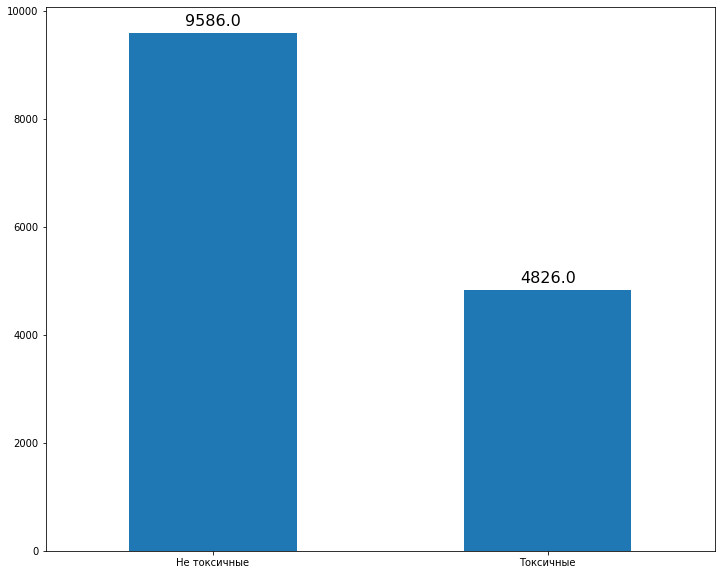

In [38]:
fig, ax = plt.subplots(figsize=(12, 10))
toxic = (df['toxic'].value_counts()).plot(kind='bar')
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=10)
# plt.grid(color='lightblue', linestyle=':')
# plt.text(0, 1, (df['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
# plt.text(1, 1, (df['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
# plt.show()

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va,
            fontsize=16,
            )                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

In [41]:
df['counts_word']= df['comment'].str.split().str.len()
df

,comment,toxic,counts_word
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,5
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,21
2,Собаке - собачья смерть\n,1.0,4
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,32
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,18
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,15
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,17
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,43
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,44


In [42]:
df["counts_word"].mean()

27.94601720788232

In [76]:
df["counts_word"].quantile(.80)


37.0

In [61]:
q95=df["counts_word"].quantile(.95)
q95

84.0

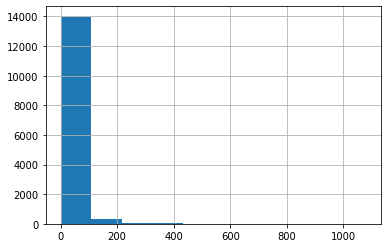

In [44]:
df["counts_word"].hist()

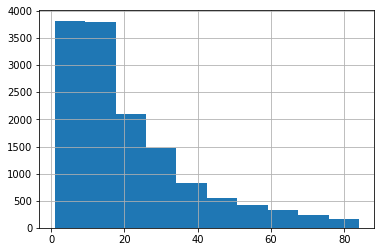

In [60]:
df[df["counts_word"]<=q95]['counts_word'].hist()

In [71]:
def q75(x):
    return x.quantile(0.75)
def q95(x):
    return x.quantile(0.95)

In [72]:
df['counts_word_group'] = pd.cut(df['counts_word'],5)

df.groupby('counts_word_group',dropna=False)['counts_word'].agg(['count','mean',q75,q95])

,count,mean,q75,q95
counts_word_group,,,,
"(-0.077, 216.4]",14309,25.535817,31.00,78.0
"(216.4, 431.8]",84,299.916667,342.25,403.4
"(431.8, 647.2]",11,534.272727,574.00,608.0
"(647.2, 862.6]",6,701.000000,725.25,775.5
"(862.6, 1078.0]",2,1045.000000,1061.50,1074.7


In [75]:
df['counts_word'].describe()

count    14412.000000
mean        27.946017
std         41.432218
min          1.000000
25%          9.000000
50%         16.000000
75%         32.000000
max       1078.000000
Name: counts_word, dtype: float64